In [1]:
using Pkg; Pkg.activate("..")

  Activating environment at `~/git/JSM2021/Project.toml`


# Using the RCall and PyCall packages

## PyCall
- Early in the development of Julia, Steven Johnson started the [PyCall package](https://github.com/JuliaPy/PyCall.jl) to interact with Python - in part to allow use of what were called *IPython notebooks* (now called *Jupyter notebooks*)
- The [IJulia package](https://github.com/JuliaLang/IJulia.jl) now provides the Julia kernel(s) for Jupyter.
- The `JuliaPy` github group also provides the [Conda.jl](https://github.com/JuliaPy/Conda.jl) package to access the Conda package manager from within Julia
- I don't have a lot of experience with Python data science tools and will show only the rudiments.

## Attach the Julia packages to be used

In [2]:
using DataFrames, PyCall, Random, RCall

The `RCall` package has a special mechanism to display R plots in a Jupyter notebook

In [3]:
RCall.ijulia_setdevice(MIME("image/svg+xml"))

## Accessing an Arrow file in Python

In [4]:
feather = pyimport("pyarrow.feather")

PyObject <module 'pyarrow.feather' from '/home/bates/.julia/conda/3/lib/python3.9/site-packages/pyarrow/feather.py'>

In [5]:
MMdatadir = expanduser(
    joinpath(
        "~",
        ".julia",
        "artifacts",
        "6d31be16850ffb7b5c0b80cb25f85b5c10df6546",
        ),
    );

In [6]:
feather.read_table(joinpath(MMdatadir, "mrk17_exp1.arrow")) # schema

PyObject pyarrow.Table
subj: dictionary<values=string, indices=int8, ordered=0> not null
item: dictionary<values=string, indices=int16, ordered=0> not null
trial: int16 not null
F: dictionary<values=string, indices=int8, ordered=0> not null
P: dictionary<values=string, indices=int8, ordered=0> not null
Q: dictionary<values=string, indices=int8, ordered=0> not null
lQ: dictionary<values=string, indices=int8, ordered=0> not null
lT: dictionary<values=string, indices=int8, ordered=0> not null
rt: int16 not null

### As a Pandas data frame

In [7]:
pdfrm = feather.read_feather(joinpath(MMdatadir, "mrk17_exp1.arrow"))

PyObject       subj   item  trial   F    P    Q   lQ  lT   rt
0      S01   CAKE      2  LF  unr  deg  deg  NW  794
1      S01  PARTY      3  HF  unr  clr  deg  WD  506
2      S01   SPOT      5  HF  rel  clr  deg  NW  491
3      S01   LONG      9  HF  rel  deg  deg  NW  486
4      S01   YEAR     10  HF  unr  deg  deg  WD  482
...    ...    ...    ...  ..  ...  ...  ...  ..  ...
16404  S73   CORN    473  LF  rel  deg  clr  WD  694
16405  S73   READ    474  HF  unr  deg  deg  WD  491
16406  S73  MOUTH    475  HF  unr  deg  deg  WD  810
16407  S73  HOTEL    477  HF  rel  deg  clr  NW  544
16408  S73  SPACE    480  HF  rel  deg  deg  NW  520

[16409 rows x 9 columns]

- and the 16409 rows are numbered 0 to 16408!

## RCall
- in the REPL the user can switch to a native R mode (`$` as first character in the line)
- otherwise use strings of the form `R"x <- rnorm(5)"` or with triple double quotes for multiple statements
- can copy objects from Julia to R using the same name with the `@rput` macro, opposite direction with `@rget`
- in general, the `rcopy` function in Julia creates a Julia copy of any R object that RCall "knows" about

In [8]:
df = DataFrame(x = 1:40, y = cumsum(randn(MersenneTwister(12321), 40))); # a DataFrame in Julia

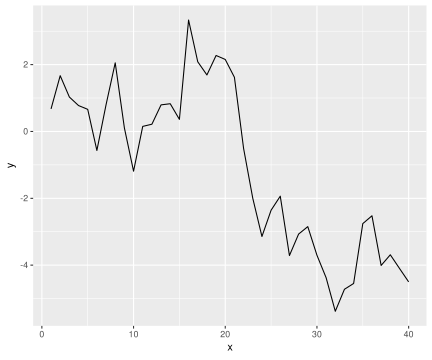

RObject{VecSxp}


In [9]:
@rput df;   # copy the Julia data frame to the R process
            # evaluate R expressions in R
R"""        
library(ggplot2)
ggplot(df, aes(x = x, y = y)) + geom_line()
"""

In [10]:
R"ls()"      # there is now a copy in the R process

RObject{StrSxp}
[1] "df"


In [11]:
R"str(df)"  # and I can check what it looks like in R

'data.frame':	40 obs. of  2 variables:
 $ x: int  1 2 3 4 5 6 7 8 9 10 ...
 $ y: num  0.674 1.668 1.029 0.775 0.662 ...


RObject{NilSxp}
NULL


### Using `@rimport` and `@rlibrary`
- RCall provides more transparent (although potentially less effective) ways of using an R package in Julia
- the `@rimport` macro creates a Julia module with the names from the R package
- the `@rlibrary` macro installs the names from the R package in the `Main` namespace
- I think it is safer to use `@rimport`

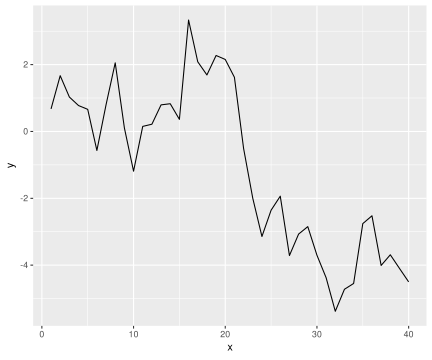

RObject{VecSxp}


In [12]:
@rimport ggplot2 as ggp
ggp.ggplot(df, ggp.aes(x = :x, y = :y)) + ggp.geom_line()

In [13]:
typeof(ggp.ggplot)

RObject{ClosSxp}

### Limitations
- There are limitations when using `@rimport` or `@rlibrary`
- The expression is parsed and the arguments are evaluated in Julia.
    + This is why the arguments in the call to `ggp.aes` are of the form `x = :x` and not `x = x`
    + The first form is valid in Julia because `:x` is a symbol.
    + The second form is only valid if `x` has a binding in the Julia session.
- Arguments like `df` are evaluated in Julia and interpolated into the call to the R object `ggp.ggplot`
    + This means that every call with an argument `df` copies the data frame over to R.
    + If you evaluate an expression like `R"ggplot(df, ...)"` instead, it re-uses the frame in R.

## RCall is 100% Julia and PyCall is 99.9% Julia code
- If you have never tried to write code to do something like this, that may seem mundane.  
- If you have tried, it will be astonishing
- Regardless of how it is accomplished, these language interfaces allow you a fallback while trying to get up to speed with a new language.